In [1]:
import sys
!{sys.executable} -m pip install simanneal


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from simanneal import Annealer
from sklearn.metrics import accuracy_score, classification_report

# Load dataset from CSV
data = pd.read_csv('../eclipse.csv')

# Convert 'post' column to binary
data['post_binary'] = data['post'].apply(lambda x: 1 if x > 0 else 0)

# Prepare the feature matrix (X) and the target vector (y)
X = data.drop(columns=['plugin', 'filename', 'pre', 'post', 'post_binary'])  # Dropping non-numeric and target columns
y = data['post_binary']

# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Define the Annealer to optimize feature subset
class FeatureSelection(Annealer):

    def move(self):
        """Swaps one feature on/off."""
        idx_to_change = np.random.randint(0, len(self.state))
        self.state[idx_to_change] = 1 - self.state[idx_to_change]  # toggle between 0 and 1

    def energy(self):
        """Evaluates the accuracy of KNN on the selected features."""
        indices = [index for index, value in enumerate(self.state) if value]
        if not indices:
            return 1e5  # Penalize if no features are selected
        
        X_train_selected = X_train[:, indices]
        X_test_selected = X_test[:, indices]
        
        clf = KNeighborsClassifier()
        clf.fit(X_train_selected, y_train)
        y_pred = clf.predict(X_test_selected)
        return -accuracy_score(y_test, y_pred)  # We negate the score as we want to maximize accuracy

# Initialize with random features
initial_state = np.random.choice([0, 1], size=X_train.shape[1])

fs = FeatureSelection(initial_state)
fs.set_schedule(fs.auto(minutes=0.2))  # You can adjust this for longer/shorter runs
state, e = fs.anneal()

selected_features = [index for index, value in enumerate(state) if value]
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Train KNN on selected features
clf = KNeighborsClassifier()
clf.fit(X_train_selected, y_train)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00007         -0.88    29.90%     0.00%     2:28:14     0:28:13 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00007         -0.86     0.00%     0.00%     0:00:11     0:00:00

KNeighborsClassifier()

Accuracy:  0.8796602170835299
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1797
           1       0.74      0.32      0.44       322

    accuracy                           0.88      2119
   macro avg       0.82      0.65      0.69      2119
weighted avg       0.87      0.88      0.86      2119



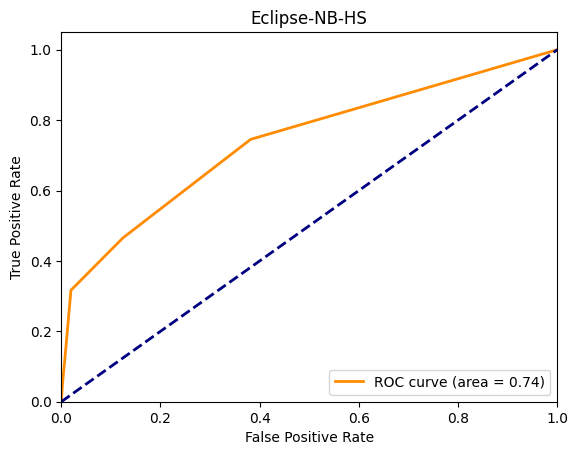

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Test the classifier
y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./Eclipse_NB_HS.csv', index=False)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Eclipse-NB-HS')
plt.legend(loc="lower right")
plt.show()